In [142]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import PROJECT.util as f
from matplotlib.pyplot import cm
from mpl_toolkits import mplot3d
import plotly.graph_objects as go
import pandas as pd

In [143]:
# Pour des vecteurs u* et v*,
# les overlaps obtenus sont soit les deux positifs ou les deux négatifs, on a:
# overlap(u*)= -x et overlap(v*)= -y ou overlap(u*)= x et overlap(v*)= y.
# on prend donc le min(u-x, u+x):

# si u est positif et x est positif:
# min(u-x, u+x) -> u-x est bon

# si u est positif et x est négatif:
# min(u-(-x), u+(-x)) -> u+(-x) =u-x est bon

# si u est négatif et x est positif:
# min(-u-x, -u+x) -> -u+x =x-u est bon

# si u est négatif et x est négatif:
# min(-u-(-x), -u+(-x)) -> -u-(-x) =x-u est bon

def mse1(u,u_n):
    ## u-u_n
    a=torch.pow((u-u_n),2).mean(0)
    b=torch.pow((u+u_n),2).mean(0)
    return torch.min(a,b)
def mse2(u_e, v_e, u_t, v_t, Y):
    ## u*v*-uv
    tmp = torch.tensordot(u_e, v_e, 0) - torch.tensordot(u_t, v_t, 0)
    return torch.sum(torch.pow((tmp), 2))
def mse3(u_e, v_e, u_t, v_t, Y):
    ## Y-uv
    tmp = Y - torch.tensordot(u_t, v_t, 0)
    return torch.sum(torch.pow((tmp), 2))

In [144]:
def main_gradient_2_sans_proj_normalisation(iteration, u_p, v_p, Y, u_, v_, N, M, lambda_, beta_u, beta_v, lambda_1, lambda_2, dt):

    res = []
    res_mse= []
    
    mod = iteration*0.1
    
    stabilisation_check=np.empty((0,2))

    for i in range(iteration):

        # Computation
        sqrt_dt = torch.sqrt(dt)

        u_1 = (1/lambda_1) * f.gradient_u_2(N, M, u_p,v_p,Y,lambda_) * dt
        u_2 = torch.sqrt(2/(lambda_1*beta_u)) * torch.empty(N).normal_(mean=0,std=sqrt_dt)
        u_3 = ((N-1)/(N*lambda_1*beta_u))*u_p*dt
        u_n = u_p - u_1 + u_2 - u_3

        v_1 = 1/lambda_2 * f.gradient_v_2(N,M,u_p,v_p,Y,lambda_) * dt
        v_2 = torch.sqrt(2/(lambda_2*beta_v)) * torch.empty(M).normal_(mean=0,std=sqrt_dt)
        v_3 = ((M-1)/(M*lambda_2*beta_v))*v_p*dt
        v_n = v_p - v_1 + v_2 - v_3

        # Normalisation
        u_n = u_n / torch.linalg.norm(u_n)
        v_n = v_n / torch.linalg.norm(v_n)
        u_n = u_n * torch.sqrt(N)
        v_n = v_n * torch.sqrt(M)

        # Re-asign for the loop
        u_p = u_n
        v_p = v_n
    
        res_u = torch.abs(f.overlap(u_,u_n,N))
        res_v = torch.abs(f.overlap(v_,v_n,M))
        res.append((res_u,res_v))
        
        res_mse.append((mse1(u_,u_n), mse1(v_,v_n)))
        
        if len(stabilisation_check)==0:
            #print("INIT")
            stabilisation_check=np.append(stabilisation_check, [[res_u,res_v]], axis=0)
        elif len(stabilisation_check)==200:
            #print("FINISH")
            print(f"overlap(u, v): ({res_u}; {res_v})")
            return np.array(res), np.array(res_mse)
        elif (np.abs(stabilisation_check-[res_u,res_v])<0.0001).all():
            #print("ADD")
            stabilisation_check=np.append(stabilisation_check, [[res_u,res_v]], axis=0)
        else:
            #print("RESET")
            stabilisation_check=np.empty((0,2))
        
        if i%mod==0:
            print(f"progress {100*i/iteration:.2f}%", end="\r")
        if i==iteration-1:
            print(f"overlap(u, v): ({res_u}; {res_v})")

    return np.array(res), np.array(res_mse)

In [145]:
def one_run(lambda_1,lambda_2, N, M,lambda_=2, beta_u=float("inf"), 
            beta_v=float("inf"),  dt=1/100, iteration=2000):
      #Size of the matrix Y
    N = torch.tensor(N)
    M = torch.tensor(M)

    # lambda
    lambda_ = torch.tensor(lambda_)

    #temperatures
    beta_u = torch.tensor(beta_u)
    beta_v = torch.tensor(beta_v)

    #learning rates
    lambda_1 = torch.tensor(lambda_1)
    lambda_2 = torch.tensor(lambda_2)

    # Pas de temps
    dt = torch.tensor(dt)

    u_ = f.generate_vector(N)
    v_ = f.generate_vector(M)

    Y = f.generate_Y(N, M, u_,v_, lambda_)
    #print(Y)

    # Conditions initiales
    u_p = f.generate_vector(N)
    v_p = f.generate_vector(M)

    # Perform the gradient descent
    (res, res_mse) = main_gradient_2_sans_proj_normalisation(iteration, u_p, v_p, Y, u_, v_, N, M, lambda_, beta_u, beta_v, lambda_1, lambda_2, dt)
    
    return res, res_mse


In [146]:
# MAIN METHOD:

def main(size_of_one_sample, list_value_1, list_value_2,lambda_u,lambda_v,d_u,d_v):
    
    all_overlap_iterations=[]
    all_final_overlaps=[]
    
    all_mse_iterations=[]
    all_final_mse=[]
    
    for value_to_test_1 in list_value_1:
        
        for value_to_test_2 in list_value_2:
        
            one_run_overlap_iterations=[]
            one_run_mse_iterations=[]

            # Calculation
            for _ in range(size_of_one_sample):
                (current_uv_overlap,current_uv_mse)=one_run(lambda_1 = lambda_u, lambda_2 = lambda_v, N = d_u, M = d_v, beta_u=value_to_test_1, beta_v=value_to_test_2)
                # Store the overlap at the end of each iterations:
                one_run_overlap_iterations.append(current_uv_overlap)
                # Store the mse at the end of each iterations:
                one_run_mse_iterations.append(current_uv_mse)

            # Store the overlap/mse at the final iteration:
            one_run_final_overlap = np.array([x[-1] for x in one_run_overlap_iterations])
            one_run_final_mse = np.array([x[-1] for x in one_run_mse_iterations])

            # Add the results of this specific run to the global array:
            # overlap at all iterations:
            all_overlap_iterations.append(one_run_overlap_iterations)
            # overlap at the final iteration:
            all_final_overlaps.append(one_run_final_overlap)
            # mse at all iterations:
            all_mse_iterations.append(one_run_mse_iterations)
            # mse at the final iteration:
            all_final_mse.append(one_run_final_mse)
            
    return np.array(all_overlap_iterations), np.array(all_final_overlaps), np.array(all_mse_iterations), np.array(all_final_mse)

In [147]:
# MAIN CELL: DO THE COMPUTATION 1

list_value_1 = np.logspace(-1,0.5,num=10)

list_value_2 = np.logspace(-1,0.5,num=10)

lambda_u_1 = 0.5
lambda_v_1 = 1

d_u_1 = 400
d_v_1 = 800

size_of_one_sample=10

(overlap_at_each_iterations, overlap_at_final_iteration,
 mse_at_each_iterations, mse_at_final_iteration) = main(size_of_one_sample, list_value_1, list_value_2,lambda_u_1,lambda_v_1,d_u_1,d_v_1)

overlap(u, v): (0.06260080635547638; 0.01597163826227188)
overlap(u, v): (0.07301133871078491; 0.0006750708562321961)
overlap(u, v): (0.06470983475446701; 0.0025062488857656717)
overlap(u, v): (0.08780685067176819; 0.02301674522459507)
overlap(u, v): (0.004769997671246529; 0.029251597821712494)
overlap(u, v): (0.017682384699583054; 0.004076869692653418)
overlap(u, v): (0.010657097212970257; 0.08290798217058182)
overlap(u, v): (0.0053505371324718; 0.056977737694978714)
overlap(u, v): (0.016669603064656258; 0.028691135346889496)
overlap(u, v): (0.023195505142211914; 0.059689950197935104)
overlap(u, v): (0.006379549391567707; 0.05307483673095703)
overlap(u, v): (0.0006567585514858365; 0.04036395251750946)
overlap(u, v): (0.07722540944814682; 0.07085316628217697)
overlap(u, v): (0.08642282336950302; 0.05638202652335167)
overlap(u, v): (0.035135459154844284; 0.02530335821211338)
overlap(u, v): (0.026579953730106354; 0.0004847574164159596)
overlap(u, v): (0.05542783811688423; 0.0215727780014

overlap(u, v): (0.06382406502962112; 0.017111176624894142)
overlap(u, v): (0.015690643340349197; 0.08989830315113068)
overlap(u, v): (0.0575035959482193; 0.013887393288314342)
overlap(u, v): (0.008224619552493095; 0.02948560193181038)
overlap(u, v): (0.01975376345217228; 0.0018443965818732977)
overlap(u, v): (0.050425950437784195; 0.0106644406914711)
overlap(u, v): (0.10642919689416885; 0.04466962814331055)
overlap(u, v): (0.01497640646994114; 0.013648361898958683)
overlap(u, v): (0.0046466137282550335; 0.02774241380393505)
overlap(u, v): (0.03832469508051872; 0.031412649899721146)
overlap(u, v): (0.05664665997028351; 0.061751093715429306)
overlap(u, v): (0.09396655857563019; 0.0711430162191391)
overlap(u, v): (0.10776796191930771; 0.07281309366226196)
overlap(u, v): (0.046976856887340546; 0.05726839229464531)
overlap(u, v): (0.041693396866321564; 0.058160386979579926)
overlap(u, v): (0.025786934420466423; 0.011433116160333157)
overlap(u, v): (0.012175317853689194; 0.07418747991323471)

overlap(u, v): (0.4764772355556488; 0.6357449889183044)
overlap(u, v): (0.4487669765949249; 0.598276674747467)
overlap(u, v): (0.44259631633758545; 0.6423161029815674)
overlap(u, v): (0.4428609609603882; 0.6557643413543701)
overlap(u, v): (0.46683546900749207; 0.607994794845581)
overlap(u, v): (0.5025085210800171; 0.6442468166351318)
overlap(u, v): (0.475797563791275; 0.6442106366157532)
overlap(u, v): (0.5033367276191711; 0.5935150980949402)
overlap(u, v): (0.44058409333229065; 0.6418377757072449)
overlap(u, v): (0.5377395749092102; 0.6455442905426025)
overlap(u, v): (0.4390733242034912; 0.6365405321121216)
overlap(u, v): (0.4869897961616516; 0.6394988298416138)
overlap(u, v): (0.4720843434333801; 0.668912947177887)
overlap(u, v): (0.4878738522529602; 0.6552243232727051)
overlap(u, v): (0.5047933459281921; 0.6539869904518127)
overlap(u, v): (0.5255174040794373; 0.6715927124023438)
overlap(u, v): (0.4569665491580963; 0.6654322147369385)
overlap(u, v): (0.4930965006351471; 0.64729368686

overlap(u, v): (0.09861228615045547; 0.021980853751301765)
overlap(u, v): (0.018448643386363983; 0.027699608355760574)
overlap(u, v): (0.05306608974933624; 0.006875383667647839)
overlap(u, v): (0.013780697248876095; 0.0012014007661491632)
overlap(u, v): (0.00018411994096823037; 0.043286651372909546)
overlap(u, v): (0.38055115938186646; 0.2247050404548645)
overlap(u, v): (0.23303119838237762; 0.16865606606006622)
overlap(u, v): (0.22770003974437714; 0.1276082545518875)
overlap(u, v): (0.16256645321846008; 0.13412748277187347)
overlap(u, v): (0.06368370354175568; 0.05808557569980621)
overlap(u, v): (0.18669617176055908; 0.09249038994312286)
overlap(u, v): (0.13325226306915283; 0.07150818407535553)
overlap(u, v): (0.20044933259487152; 0.14069993793964386)
overlap(u, v): (0.19863678514957428; 0.10011737048625946)
overlap(u, v): (0.062300387769937515; 0.043551646173000336)
overlap(u, v): (0.4218789339065552; 0.2741566002368927)
overlap(u, v): (0.4606839418411255; 0.3799319863319397)
overlap

overlap(u, v): (0.6903132796287537; 0.5703835487365723)
overlap(u, v): (0.7011128067970276; 0.6188096404075623)
overlap(u, v): (0.68109530210495; 0.6334506273269653)
overlap(u, v): (0.6204683184623718; 0.5990399122238159)
overlap(u, v): (0.6803297400474548; 0.6325113773345947)
overlap(u, v): (0.7057897448539734; 0.6684832572937012)
overlap(u, v): (0.6393644213676453; 0.624612033367157)
overlap(u, v): (0.6799002289772034; 0.6232408881187439)
overlap(u, v): (0.6899974346160889; 0.6599597334861755)
overlap(u, v): (0.6555759906768799; 0.5723094344139099)
overlap(u, v): (0.6849899291992188; 0.6648707389831543)
overlap(u, v): (0.7100244164466858; 0.6958059668540955)
overlap(u, v): (0.6961683630943298; 0.6694645881652832)
overlap(u, v): (0.6938298940658569; 0.6623311042785645)
overlap(u, v): (0.6696829199790955; 0.6343738436698914)
overlap(u, v): (0.6796248555183411; 0.6581202745437622)
overlap(u, v): (0.6816523671150208; 0.6360751390457153)
overlap(u, v): (0.6930729746818542; 0.6447287201881

overlap(u, v): (0.16380241513252258; 0.08887206763029099)
overlap(u, v): (0.04717709496617317; 0.01596030779182911)
overlap(u, v): (0.07217545807361603; 0.04397406429052353)
overlap(u, v): (0.1389423906803131; 0.014517731964588165)
overlap(u, v): (0.07406902313232422; 0.022568779066205025)
overlap(u, v): (0.028829311951994896; 0.01951100118458271)
overlap(u, v): (0.41093909740448; 0.19675152003765106)
overlap(u, v): (0.39119598269462585; 0.24603140354156494)
overlap(u, v): (0.32647761702537537; 0.17172057926654816)
overlap(u, v): (0.3657395541667938; 0.1698126196861267)
overlap(u, v): (0.21217073500156403; 0.027915453538298607)
overlap(u, v): (0.523929238319397; 0.2392655611038208)
overlap(u, v): (0.5361265540122986; 0.23380593955516815)
overlap(u, v): (0.4631255269050598; 0.20432937145233154)
overlap(u, v): (0.4397348165512085; 0.2154783010482788)
overlap(u, v): (0.411456823348999; 0.17767013609409332)
overlap(u, v): (0.5572227239608765; 0.3099081814289093)
overlap(u, v): (0.475112736

overlap(u, v): (0.6816428899765015; 0.526930570602417)
overlap(u, v): (0.7613216638565063; 0.5862747430801392)
overlap(u, v): (0.7720201015472412; 0.6352972984313965)
overlap(u, v): (0.756481409072876; 0.5917333364486694)
overlap(u, v): (0.7600300312042236; 0.5933647751808167)
overlap(u, v): (0.724800169467926; 0.6185370683670044)
overlap(u, v): (0.7948877215385437; 0.5991503000259399)
overlap(u, v): (0.734859824180603; 0.6118476390838623)
overlap(u, v): (0.7304471731185913; 0.5781013369560242)
overlap(u, v): (0.7472936511039734; 0.6043840646743774)
overlap(u, v): (0.7549158334732056; 0.5816124081611633)
overlap(u, v): (0.7422424554824829; 0.6153671145439148)
overlap(u, v): (0.7896559834480286; 0.6752285957336426)
overlap(u, v): (0.7825556397438049; 0.6675883531570435)
overlap(u, v): (0.7857956886291504; 0.6712560057640076)
overlap(u, v): (0.7953823804855347; 0.6638617515563965)
overlap(u, v): (0.7609468102455139; 0.656217634677887)
overlap(u, v): (0.7492111325263977; 0.611980795860290

In [148]:
# MAIN CELL: DO THE COMPUTATION 2

lambda_u_2 = 1
lambda_v_2 = 1

d_u_2 = 500
d_v_2 = 500

(overlap_at_each_iterations_2, overlap_at_final_iteration_2,
 mse_at_each_iterations_2, mse_at_final_iteration_2) = main(size_of_one_sample, list_value_1, list_value_2,lambda_u_2,lambda_v_2,d_u_2,d_v_2)

overlap(u, v): (0.0532722994685173; 0.034910328686237335)
overlap(u, v): (0.010578430257737637; 0.06012497842311859)
overlap(u, v): (0.026291649788618088; 0.009825881570577621)
overlap(u, v): (0.07390841841697693; 0.024919159710407257)
overlap(u, v): (0.01980150304734707; 0.04884859919548035)
overlap(u, v): (0.061612311750650406; 0.051517385989427567)
overlap(u, v): (0.04151245951652527; 0.04477030411362648)
overlap(u, v): (0.0377383790910244; 0.0024992122780531645)
overlap(u, v): (0.03352552652359009; 0.054350800812244415)
overlap(u, v): (0.035355597734451294; 0.01152049284428358)
overlap(u, v): (0.017329679802060127; 0.038546737283468246)
overlap(u, v): (0.07413052022457123; 0.02626943401992321)
overlap(u, v): (0.012082377448678017; 0.037778958678245544)
overlap(u, v): (0.08271081000566483; 0.06684298068284988)
overlap(u, v): (0.01412271335721016; 0.028547542169690132)
overlap(u, v): (0.04387563839554787; 0.1083185151219368)
overlap(u, v): (0.009161284193396568; 0.019612625241279602)

overlap(u, v): (0.09000172466039658; 0.005115000531077385)
overlap(u, v): (0.0409097895026207; 0.05719303712248802)
overlap(u, v): (0.018663546070456505; 0.01054698508232832)
overlap(u, v): (0.06651473790407181; 0.10342980921268463)
overlap(u, v): (0.03210655599832535; 0.030451269820332527)
overlap(u, v): (0.01760045997798443; 0.017081616446375847)
overlap(u, v): (0.04126300662755966; 0.017292670905590057)
overlap(u, v): (0.09401408582925797; 0.1053415834903717)
overlap(u, v): (0.025174595415592194; 0.11586784571409225)
overlap(u, v): (0.060095757246017456; 0.058415137231349945)
overlap(u, v): (0.04195931553840637; 0.010691089555621147)
overlap(u, v): (0.049468766897916794; 0.008239112794399261)
overlap(u, v): (0.02008754573762417; 0.017675021663308144)
overlap(u, v): (0.051715005189180374; 0.05929233506321907)
overlap(u, v): (0.006852114573121071; 0.017833400517702103)
overlap(u, v): (0.060728203505277634; 0.10032631456851959)
overlap(u, v): (0.0325743593275547; 0.04579828307032585)
o

overlap(u, v): (0.08632498979568481; 0.25706782937049866)
overlap(u, v): (0.2620140314102173; 0.3249622881412506)
overlap(u, v): (0.046433065086603165; 0.2781532108783722)
overlap(u, v): (0.21154795587062836; 0.33471471071243286)
overlap(u, v): (0.13743674755096436; 0.3591754734516144)
overlap(u, v): (0.17940279841423035; 0.4318249225616455)
overlap(u, v): (0.1455584168434143; 0.3983370065689087)
overlap(u, v): (0.13680166006088257; 0.4536292254924774)
overlap(u, v): (0.09376237541437149; 0.2826862037181854)
overlap(u, v): (0.19099117815494537; 0.3273867964744568)
overlap(u, v): (0.14384223520755768; 0.24203704297542572)
overlap(u, v): (0.1733839362859726; 0.4240991771221161)
overlap(u, v): (0.23115670680999756; 0.3816203773021698)
overlap(u, v): (0.18810421228408813; 0.43707624077796936)
overlap(u, v): (0.10194581747055054; 0.3331836462020874)
overlap(u, v): (0.21217690408229828; 0.37144890427589417)
overlap(u, v): (0.14391036331653595; 0.337411105632782)
overlap(u, v): (0.20163153111

overlap(u, v): (0.04766972362995148; 0.0409029982984066)
overlap(u, v): (0.044766616076231; 0.04087740555405617)
overlap(u, v): (0.0502646379172802; 0.015305938199162483)
overlap(u, v): (0.04291684553027153; 0.02522343397140503)
overlap(u, v): (0.0794166848063469; 0.006057353224605322)
overlap(u, v): (0.08013743907213211; 0.003610703395679593)
overlap(u, v): (0.09738033264875412; 0.0039551276713609695)
overlap(u, v): (0.05347801372408867; 0.022333305329084396)
overlap(u, v): (0.06000311300158501; 0.03202151134610176)
overlap(u, v): (0.043816957622766495; 0.03748559206724167)
overlap(u, v): (0.04592062160372734; 0.056790683418512344)
overlap(u, v): (0.16976416110992432; 0.10424957424402237)
overlap(u, v): (0.055844731628894806; 0.04494407773017883)
overlap(u, v): (0.025098614394664764; 0.008468873798847198)
overlap(u, v): (0.020603520795702934; 0.0065279691480100155)
overlap(u, v): (0.20481976866722107; 0.10562411695718765)
overlap(u, v): (0.007443054113537073; 0.004663171712309122)
ove

overlap(u, v): (0.43721315264701843; 0.46356847882270813)
overlap(u, v): (0.4249153435230255; 0.48313891887664795)
overlap(u, v): (0.39927437901496887; 0.43823912739753723)
overlap(u, v): (0.36436110734939575; 0.38044819235801697)
overlap(u, v): (0.44237908720970154; 0.4340985119342804)
overlap(u, v): (0.45900797843933105; 0.512405276298523)
overlap(u, v): (0.42292219400405884; 0.4290570318698883)
overlap(u, v): (0.4044168293476105; 0.5147593021392822)
overlap(u, v): (0.4507827162742615; 0.45600321888923645)
overlap(u, v): (0.5066196918487549; 0.49592921137809753)
overlap(u, v): (0.48935145139694214; 0.5653740167617798)
overlap(u, v): (0.41022276878356934; 0.4684488773345947)
overlap(u, v): (0.46200111508369446; 0.48859626054763794)
overlap(u, v): (0.41534173488616943; 0.4635067880153656)
overlap(u, v): (0.4760550260543823; 0.5389947891235352)
overlap(u, v): (0.41471201181411743; 0.47009551525115967)
overlap(u, v): (0.5137317180633545; 0.5587490797042847)
overlap(u, v): (0.413074225187

overlap(u, v): (0.04404609650373459; 0.07107271999120712)
overlap(u, v): (0.02514314465224743; 0.00048585128388367593)
overlap(u, v): (0.17487061023712158; 0.10154740512371063)
overlap(u, v): (0.009207199327647686; 0.002098997589200735)
overlap(u, v): (0.0340588316321373; 0.03934669494628906)
overlap(u, v): (0.002152069006115198; 0.09249842911958694)
overlap(u, v): (0.08491035550832748; 0.07063772529363632)
overlap(u, v): (0.10320527106523514; 0.01783156581223011)
overlap(u, v): (0.021571801975369453; 0.008074342273175716)
overlap(u, v): (0.02287190593779087; 0.055757589638233185)
overlap(u, v): (0.03466072306036949; 0.03366576507687569)
overlap(u, v): (0.15049128234386444; 0.13587570190429688)
overlap(u, v): (0.03687157481908798; 0.1169351190328598)
overlap(u, v): (0.08685704320669174; 0.011757166124880314)
overlap(u, v): (0.2688705325126648; 0.13414785265922546)
overlap(u, v): (0.17525127530097961; 0.059282246977090836)
overlap(u, v): (0.21465182304382324; 0.10275226086378098)
overla

overlap(u, v): (0.5741896629333496; 0.47818535566329956)
overlap(u, v): (0.5784147381782532; 0.46977338194847107)
overlap(u, v): (0.4967639148235321; 0.429403692483902)
overlap(u, v): (0.565735936164856; 0.4871784448623657)
overlap(u, v): (0.5795904397964478; 0.45919179916381836)
overlap(u, v): (0.5626305937767029; 0.4794434905052185)
overlap(u, v): (0.5368555188179016; 0.4574190080165863)
overlap(u, v): (0.5952067375183105; 0.5192221403121948)
overlap(u, v): (0.5971168875694275; 0.5005887150764465)
overlap(u, v): (0.5956733226776123; 0.5629638433456421)
overlap(u, v): (0.6329505443572998; 0.5835996270179749)
overlap(u, v): (0.6173373460769653; 0.5592656135559082)
overlap(u, v): (0.6085907816886902; 0.5792352557182312)
overlap(u, v): (0.6048663258552551; 0.5742753744125366)
overlap(u, v): (0.6186439394950867; 0.5148025751113892)
overlap(u, v): (0.5575823187828064; 0.5216750502586365)
overlap(u, v): (0.6203153133392334; 0.618918240070343)
overlap(u, v): (0.5807561874389648; 0.5663073658

overlap(u, v): (0.5997213125228882; 0.654430627822876)
overlap(u, v): (0.6282438039779663; 0.6639353036880493)
overlap(u, v): (0.676673173904419; 0.6524978280067444)


In [149]:
name_value_u="beta_u"
name_value_v="beta_v"
name_d_u_1 = str(d_u_1)
name_d_v_1 = str(d_v_1)
name_d_u_2 = str(d_u_2)
name_d_v_2 = str(d_v_2)

FILE_PATH="/Users/constantindebentzmann/Desktop/plots/"

In [150]:
#### MSE 3D PLOT BOTH CONFIG
x, y = np.meshgrid(list_value_2,list_value_1)
mse_mean=mse_at_final_iteration.mean(axis=1).mean(axis=1)
mse_mean=mse_mean.reshape(len(list_value_1),len(list_value_2))

mse_mean_2=mse_at_final_iteration_2.mean(axis=1).mean(axis=1)
mse_mean_2=mse_mean_2.reshape(len(list_value_1),len(list_value_2))

fig = go.Figure(data=[
    go.Surface(name=f"n={d_u_1}, m={d_v_1}; lu={lambda_u_1}, lv={lambda_v_1}",
               z=mse_mean,x=list_value_1, y=list_value_2,
               colorscale ='Blues', showscale=False, opacity=1),
    go.Surface(name=f"n={d_u_2}, m={d_v_2}; lu={lambda_u_2}, lv={lambda_v_2}",
               z=mse_mean_2,x=list_value_1, y=list_value_2,
               colorscale ='Greens', showscale=False, opacity=0.9)])

fig.update_layout(
    title=f"MSE:",
)
fig.update_layout(scene = dict(
                    xaxis_title=name_value_u,
                    yaxis_title=name_value_v,
                    zaxis_title="mse"))
fig.update_traces(showlegend=True)

fig.show()
path=f"{FILE_PATH}R1_n={d_u_1}_m={d_v_1}_"\
f"Ldiff={lambda_u_1/lambda_v_1}_"\
f"R2_n={d_u_2}_m={d_v_2}_"\
f"Ldiff={lambda_u_2/lambda_v_2}_mse.html"
fig.write_html(path)

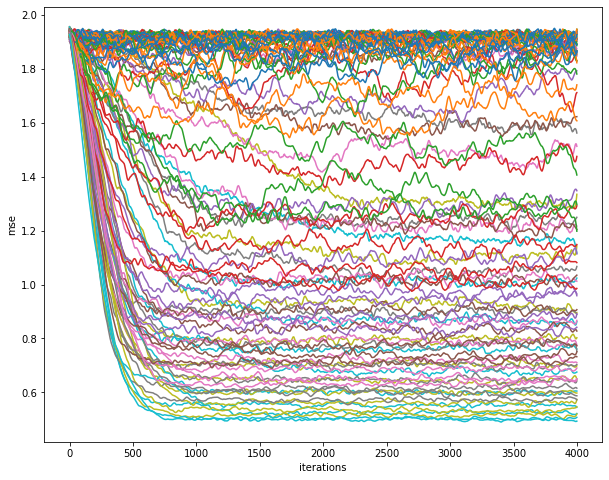

In [151]:
#### MSE in function fo iteration
from scipy.signal import savgol_filter
mse_data = mse_at_each_iterations.mean(axis=3).mean(axis=1)
plt.figure(figsize=((10,8)))
for i in range(size_of_one_sample**2):
    plt.plot(savgol_filter(mse_data[i], 51, 3))
plt.ylabel("mse")
plt.xlabel("iterations")
path_plot=f"{FILE_PATH}R1_n={d_u_1}_m={d_v_1}_"\
f"Ldiff={lambda_u_1/lambda_v_1}_"\
f"R2_n={d_u_2}_m={d_v_2}_"\
f"Ldiff={lambda_u_2/lambda_v_2}_mse_plot.png"
plt.savefig(path_plot)
plt.show()


In [162]:
# STABILISATION MSE AVEC PLOTLY
# CHANGER SELECTED_RUN !
selected_run=0

var_u,var_v=np.var(mse_at_each_iterations[selected_run], axis=0).T
mse_u,mse_v=mse_at_each_iterations.mean(1)[selected_run].T

x=[i for i in range(len(mse_u))]

fig=go.Figure(data=[go.Scatter(
        x=x,
        y=mse_u,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=var_u,
            visible=True),
        name="u mse"
    ),
      go.Scatter(
        x=x,
        y=mse_v,
        error_y=dict(
            type='data', # value of error bar given in data coordinates
            array=var_v,
            visible=True),
        name="v mse"     
      )])

fig.update_layout(
    title="Stabilisation mse pour: "+f"{name_value_u}={list_value_1[selected_run//len(list_value_2)]}"
                    + f" & {name_value_v}={list_value_2[selected_run%len(list_value_2)]}",
    xaxis_title="Iterations",
    yaxis_title="MSE",
)

fig.show()

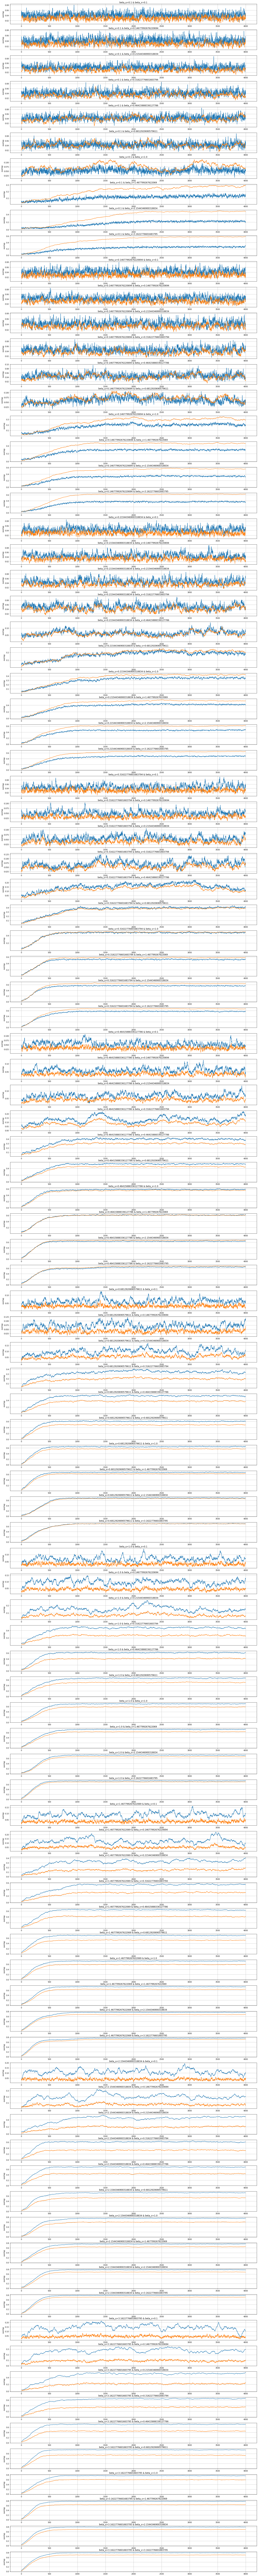

In [163]:
# GRAPH STABILISATION DES OVERLAPS
fig, axs = plt.subplots(len(list_value_1)*len(list_value_2), figsize=(20,200), facecolor='white')
fig.tight_layout()

for i in range(len(list_value_1)*len(list_value_2)):
    axs[i].grid()
    axs[i].set_ylabel("overlap")
    axs[i].set_title(f"{name_value_u}={list_value_1[i//len(list_value_2)]}"
                    + f" & {name_value_v}={list_value_2[i%len(list_value_2)]}")
    #for run_in_on_sample in range(size_of_one_sample):
    axs[i].plot(overlap_at_each_iterations.mean(1)[i])